# CDS API plugin for EODAG

In this tutorial we will show you how to use eodag to download data from providers using [CdsApi](https://eodag.readthedocs.io/en/latest/plugins_reference/generated/eodag.plugins.apis.cds.CdsApi.html) `eodag` plugin. You can currently find two providers that uses it, `cop_ads` and `cop_cds`. For this tutorial we will use `cop_ads`, but `cop_cds` is used the same way. 

In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_ads")

## Search (build download request)

There are two use case, a search for a product already configured in EODAG, or a search for a dataset not already configured, where you will have a little more to do.

For performance purpose, we can add a `variable` (Temperature, `temperature`) and one `model_level` to the request because `CAMS_EAC4` is configured to request for some pre-configured values. Check the dataset available values to make your selection.

> Note: specifying your own variables will completely overwrite default values configured for `CAMS_EAC4` product type.

### Search from an existing product type:

In [2]:
# Request for all parameters
products_from_product_type, total_count = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
)
print(
    "%s product built %s,\n having variable=%s\nand model_level=%s\n"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties["variable"],
        products_from_product_type[0].properties["model_level"],
    )
)
# Request for temperature on one model level
products_from_product_type, total_count = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    variable="temperature",
    model_level="1",
)
print(
    "%s product built %s,\n having variable=%s\nand model_level=%s\n"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties["variable"],
        products_from_product_type[0].properties["model_level"],
    )
)

1 product built EOProduct(id=CAMS_EAC4_20210101_9fa1614f23014d2fb17c38927a5e87ecb3dcf6aa, provider=cop_ads),
 having variable=['dust_aerosol_0.03-0.55um_mixing_ratio', 'dust_aerosol_0.55-0.9um_mixing_ratio', 'dust_aerosol_0.9-20um_mixing_ratio', 'dust_aerosol_optical_depth_550nm', 'hydrophilic_black_carbon_aerosol_mixing_ratio', 'hydrophilic_organic_matter_aerosol_mixing_ratio', 'hydrophobic_black_carbon_aerosol_mixing_ratio', 'hydrophobic_organic_matter_aerosol_mixing_ratio', 'sea_salt_aerosol_0.03-0.5um_mixing_ratio', 'sea_salt_aerosol_0.5-5um_mixing_ratio', 'sea_salt_aerosol_5-20um_mixing_ratio', 'sea_salt_aerosol_optical_depth_550nm', 'sulphate_aerosol_optical_depth_550nm']
and model_level=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',

### Search using a custom request:

Here we use a set of custom parameters corresponding to `CAMS_EAC4`, which should result to the same request sent to ads.

In [3]:
ads_req_params = {
    "dataset": "cams-global-reanalysis-eac4",
    "stream": "oper",
    "class": "mc",
    "expver": "0001",
    "step": 0,
    "variable": "temperature",
    "model_level": "1",
    "time": "00:00",
    "format": "netcdf",
}

products_from_ads_req, total_count = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    **ads_req_params,
)
# downloadLink property must be the same with the two request methods,
# as they are built from the same ADS request arguments
if (
    products_from_ads_req[0].properties["downloadLink"]
    == products_from_product_type[0].properties["downloadLink"]
):
    print(
        "Request using productType or directly ADS parameters result to the\n",
        "same downloadLink %s"
        % (
            products_from_ads_req[0].properties["downloadLink"],
        )
    )

Request using productType or directly ADS parameters result to the
 same downloadLink https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?date=2021-01-01/2021-01-01&area=90.0/-180.0/-90.0/180.0&class=mc&dataset=cams-global-reanalysis-eac4&expver=0001&format=netcdf&model_level=1&step=0&stream=oper&time=00:00&variable=temperature


### Send product retrieval request and download when available

- download performed using ADS credentials set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    cop_ads:
        priority:
        api:
            outputs_prefix: /data/eodag_data
            credentials:
                username: my-ads-uid
                password: my-ads-api-key
```
- you can check your request status from https://ads.atmosphere.copernicus.eu/cdsapp#!/yourrequests
- See [support](https://ads.atmosphere.copernicus.eu/cdsapp#!/usersupport) for any problem related to the provider

In [4]:
product_path = dag.download(products_from_product_type[0])
product_path

'/data/eodag_data/CAMS_EAC4_20210101_63a610e702b9132d1fca308e390ebd89f336f812.nc'

### Open dataset with `xarray` and plot using `matplotlib`

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
ds = xr.load_dataset(product_path)
ds

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 1)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2021-01-01
Data variables:
    t          (time, latitude, longitude) float32 257.2 257.2 ... 243.7 243.7
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-13 14:38:48 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

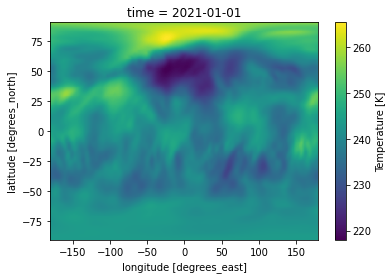

In [7]:
ds.t.plot()